# Задание

Построить модель прогнозирования продаж, которая учитывает день недели и акцию.
Описание колонок:

## sales_raw.csv:
* date
* item_id - Код товара
* qnty - Количество продаж за день


## discounts_raw.csv

* item_id - Код товара
* promo_type_code - Код типа акции
* sale_price_before_promo - Цена до акции
* sale_price_time_promo - Цена на акцию
* date_start - Дата начала акции
* date_end - Дата окончания акции

## Необходимо получить прогнозы, в которых имеются такие поля predictions.csv:
* date - дата прогноза
* item_id - Код товара
* prediction - Количество товара (дробное число)

прогноз должен быть построен на январь 2024 года по всем товарам, которые участвовали в продажах в декабре 2023. Разделитель в файле ';'.

## Метрика оценки качества прогноза
RMSE


# План действий

**План действий**
1. Исследование данных
2. Предварительный анализ данных (EDA)
3. Предварительная обработка данных
4. Манипулирование данными
5. Выбор/извлечение признаков
6. Прогнозное моделирование
7. Результаты проекта и заключение

# 1. Исследование данных

In [2]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
'''
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
'''
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Importing the datasets
discounts = pd.read_csv('/content/discounts_raw.csv')
sales = pd.read_csv('/content/sales_raw.csv')

original_discounts = discounts.copy(deep=True)
original_sales = sales.copy(deep=True)

In [4]:
sales.head()

,date,item_id,qnty
0,2017-01-01,100001,7.0
1,2017-01-01,100003,2.0
2,2017-01-01,100006,13.0
3,2017-01-01,100010,5.0
4,2017-01-01,100035,53.0


In [5]:
discounts.head()

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,100551,5.0,159.9,139.9,2023-03-02,2023-03-15
1,100553,5.0,159.9,139.9,2023-03-02,2023-03-15
2,100554,5.0,159.9,139.9,2023-03-02,2023-03-15
3,100558,5.0,159.9,139.9,2023-03-02,2023-03-15
4,100530,2.0,36.9,24.6,2021-09-09,2021-09-22


In [ ]:
# Reframing the columns

discounts.date_starts=pd.to_datetime(discounts.date_start)
discounts.date_end=pd.to_datetime(discounts.date_end)
sales.date=pd.to_datetime(sales.date)

sales['day'] = sales.date.dt.day
sales['month'] = sales.date.dt.month
sales['year'] = sales.date.dt.year

''''''
#sales.drop(['date'], axis=1, inplace=True)

In [7]:
#Checking the dtypes of all the columns
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147143 entries, 0 to 147142
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     147143 non-null  datetime64[ns]
 1   item_id  147143 non-null  int64         
 2   qnty     147143 non-null  float64       
 3   day      147143 non-null  int64         
 4   month    147143 non-null  int64         
 5   year     147143 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 6.7 MB


In [8]:
discounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   item_id                  2081 non-null   int64         
 1   promo_typeCode           2041 non-null   float64       
 2   sale_price_before_promo  2081 non-null   float64       
 3   sale_price_time_promo    2081 non-null   float64       
 4   date_start               2081 non-null   object        
 5   date_end                 2081 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 97.7+ KB


In [9]:
#Checking number of unique rows in each feature

sales.nunique().sort_values()

year          7
month        12
day          31
item_id     100
qnty        487
date       2556
dtype: int64

In [10]:
discounts.nunique().sort_values()

promo_typeCode              10
item_id                     84
sale_price_time_promo      108
sale_price_before_promo    135
date_end                   241
date_start                 264
dtype: int64

In [11]:
#Checking the stats of all the columns
sales.describe()

,item_id,qnty,day,month,year
count,147143.000000,147143.000000,147143.000000,147143.000000,147143.000000
mean,99552.401038,8.778191,15.769510,6.521833,2019.974861
std,8819.498659,27.696091,8.809118,3.472087,2.016643
min,11200.000000,-3.000000,1.000000,1.000000,2017.000000
25%,100257.000000,1.000000,8.000000,3.000000,2018.000000
50%,100486.000000,3.000000,16.000000,7.000000,2020.000000
75%,100601.000000,7.000000,23.000000,10.000000,2022.000000
max,100691.000000,1201.000000,31.000000,12.000000,2023.000000


# 2. EDA

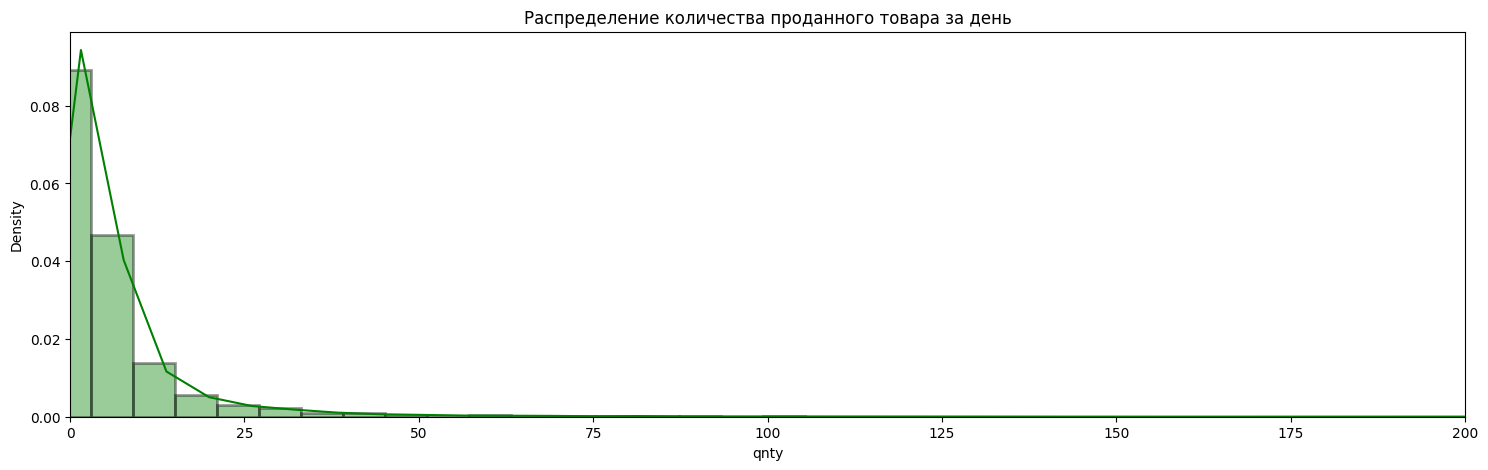

In [12]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[18,5])
sns.distplot(sales.qnty, color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=200)
plt.title('Распределение количества проданного товара за день')
plt.xlim(0,200) # длинный правый хвост на данном графике неинформативен
plt.show()

**Вывод:** распределение напоминает логнормальное.

<Axes: title={'center': 'Ящик с усами для переменной qnty(количество проданного товара за день)'}, xlabel='qnty'>

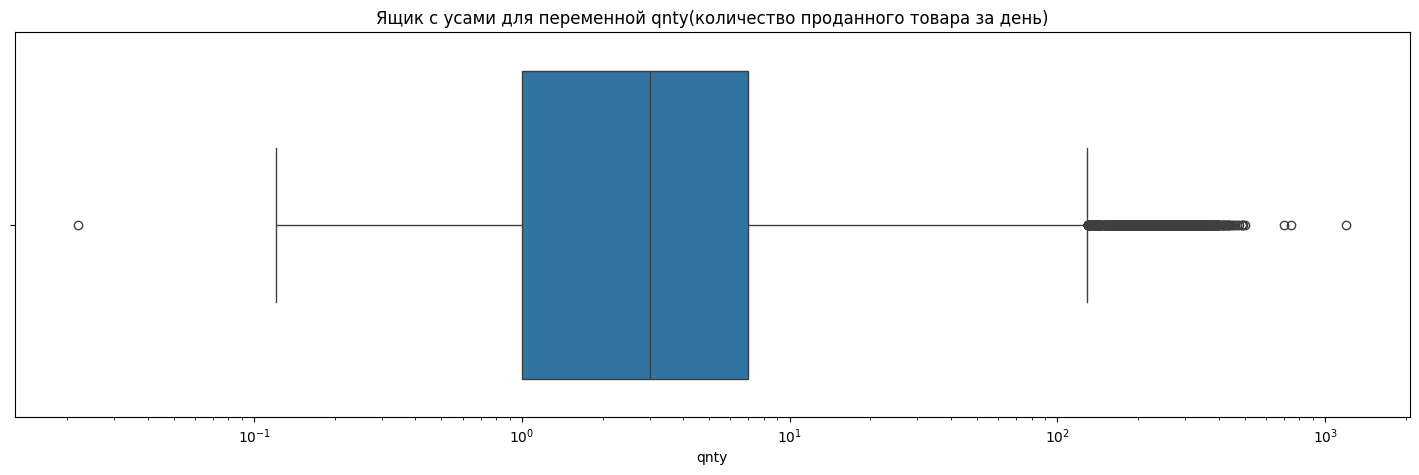

In [13]:
plt.figure(figsize=[18,5])
plt.title('Ящик с усами для переменной qnty(количество проданного товара за день)')
sns.boxplot(sales.qnty, orient='h', log_scale=True)

**Вывод:** Имеются выбросы

In [14]:
'''
x=sales.date
y=sales.qnty
sns.scatterplot(data=sales, x=x, y=y)

fit = np.polyfit(x, y, deg=1)
p = np.poly1d(fit)
plt.plot(x,p(x),"r--")
plt.show()
'''

'\nx=sales.date\ny=sales.qnty\nsns.scatterplot(data=sales, x=x, y=y)\n\nfit = np.polyfit(x, y, deg=1)\np = np.poly1d(fit)\nplt.plot(x,p(x),"r--")\nplt.show()\n'

Какую информацию можно еще из этого извлечь, может продажи по дням недели в среднем?

или по месяцам года

или по годам

тогда нужно суммировать qnty

In [15]:
grpb = sales.groupby(by=[sales.year, sales.month]).agg({'sum'})
grpb.head()

item_id       qnty    day
                  sum        sum    sum
year month                             
2017 1      186287269  12252.000  30118
     2      176556612  13155.010  25361
     3      188199986  12901.010  29693
     4      184182499  11306.990  28891
     5      184990305  12145.535  29383

In [16]:
#grpb.index[0]

In [17]:
from pandas.core.tools.datetimes import to_datetime

ind = [to_datetime(str(i[0]) + '-' + str(i[1]) + '-' + '01 00:00:00.000000000') for i in grpb.index]
ind[0]

Timestamp('2017-01-01 00:00:00')

<Axes: >

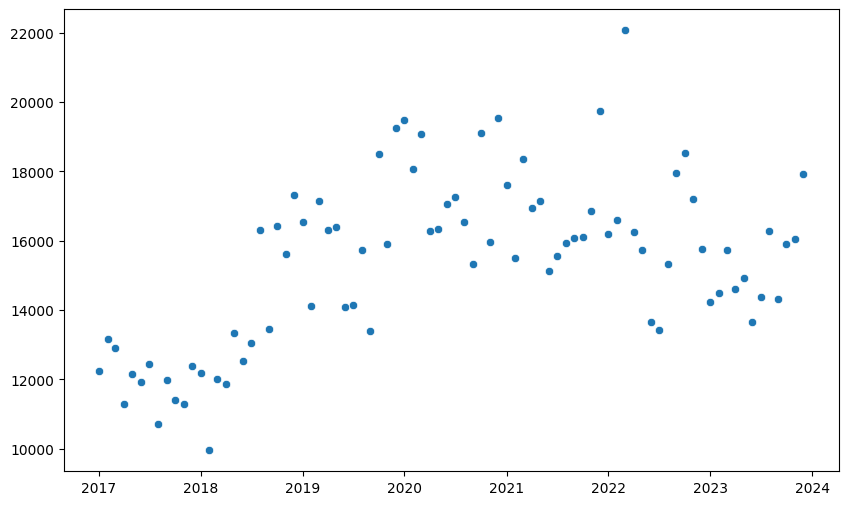

In [18]:
sns.scatterplot(data=grpb, y=grpb.qnty['sum'].values, x=ind)

**Вывод:** (на глаз) сдредний объем продаж всех позиций падал с 2017 по 2018, затем с 2018 по 2022 рос, с 2022 по сегодняшний день наблюдается спад

# 3. Data Preprocessing

## Проверка дублирующихся строк

In [19]:
# Поиск и удаление дублирующихся строк

counter = 0
rs,cs = sales.shape
sales.drop_duplicates(inplace=True)

if sales.shape==(rs,cs):
    print('Дубликатов нет')
else:
    print(f'Количество удаленных дубликатов ---> {rs-sales.shape[0]}')

Дубликатов нет


In [20]:
counter = 0
rs,cs = sales.shape
print(len(discounts))
discounts.drop_duplicates(inplace=True)
print(len(discounts))

2081
2081


Как видно, во втором датафрайме тоже нет дубликатов.

## Проверка пропущенных значений

In [21]:
nvc = pd.DataFrame(sales.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/sales.shape[0],3)*100
print(nvc)

         Total Null Values  Percentage
date                     0         0.0
item_id                  0         0.0
qnty                     0         0.0
day                      0         0.0
month                    0         0.0
year                     0         0.0


In [22]:
#Check for empty elements

nvc = pd.DataFrame(discounts.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/discounts.shape[0],3)*100
print(nvc)

                         Total Null Values  Percentage
item_id                                  0         0.0
sale_price_before_promo                  0         0.0
sale_price_time_promo                    0         0.0
date_start                               0         0.0
date_end                                 0         0.0
promo_typeCode                          40         1.9


In [23]:
discounts.promo_typeCode.unique()

array([ 5.,  2.,  8.,  6., 10., nan, 44., 23.,  7., 16.,  1.])

В наборе discounts в поле promo_typeCode имеется 40 nan значений. Заменим их на 0.

In [24]:
nan_ind = discounts[discounts.promo_typeCode.isnull()].index
discounts.loc[nan_ind,'promo_typeCode'] = 0

In [25]:
discounts.promo_typeCode.unique()

array([ 5.,  2.,  8.,  6., 10.,  0., 44., 23.,  7., 16.,  1.])

In [26]:
# Перевод категориальных признаков в числовые не требуется
# нормализация тоже

# 4. Data Manipulation

В условии сказано, что модель должна учитывать день недели и скидку. А также, что прогноз нужен на товары, которые были в продаже в декабре 2023.

In [27]:
# Создадим массив id товаров, которые были в продаже в декабре 2023

dec_2023 = sales[sales.date >= '2023-12-01']
ids_sales_in_dec_2023 = dec_2023.item_id.unique()
ids_all = sales.item_id.unique()

print('В декабре не было следующих товаров: ', set(ids_all).difference(set(ids_sales_in_dec_2023)))

В декабре не было следующих товаров:  {100464, 100652, 100511}


НУжно понять, что у нас за данные. Это количество продаж конкретных товаров в конкретные дни. Но не каждый товар продавался в каждый из дней месяца. Соответственно один и тот же item_id появляется в рамках месяца несколько раз, с разными qnty. Что тогда предсказываем и как?

**Надо ли тогда дополнить данные нулевыми qnty в тех местах, где на какой-то день для какого-то item_id нет записи? Чтобы у нас для каждого дня (каждого месяца, года) для каждого item_id была информация о количестве проданных в этот день единиц.**

In [28]:
dec_2023

,date,item_id,qnty,day,month,year
145170,2023-12-01,100545,3.0,1,12,2023
145171,2023-12-01,100645,4.0,1,12,2023
145172,2023-12-01,100683,1.0,1,12,2023
145173,2023-12-01,100612,10.0,1,12,2023
145174,2023-12-01,100165,15.0,1,12,2023
...,...,...,...,...,...,...
147138,2023-12-31,100614,5.0,31,12,2023
147139,2023-12-31,100140,4.0,31,12,2023
147140,2023-12-31,100650,11.0,31,12,2023
147141,2023-12-31,100182,1.0,31,12,2023


In [29]:
sales[sales.date >= '2023-12-01'][sales.item_id==100165]

,date,item_id,qnty,day,month,year
145174,2023-12-01,100165,15.0,1,12,2023
145248,2023-12-02,100165,13.0,2,12,2023
145359,2023-12-03,100165,19.0,3,12,2023
145409,2023-12-04,100165,6.0,4,12,2023
145465,2023-12-05,100165,9.0,5,12,2023
145534,2023-12-06,100165,14.0,6,12,2023
145554,2023-12-07,100165,12.0,7,12,2023
145665,2023-12-08,100165,15.0,8,12,2023
145718,2023-12-09,100165,13.0,9,12,2023
145752,2023-12-10,100165,10.0,10,12,2023


In [30]:
nov_2023 = sales[(sales.date >= '2023-11-01') & (sales.date < '2023-12-01')]
len(dec_2023[sales.item_id==100165]), len(nov_2023[sales.item_id==100165])

(31, 30)

In [31]:
len(dec_2023[sales.item_id==100614]), len(nov_2023[sales.item_id==100614])

(28, 29)

In [32]:
len(dec_2023[sales.item_id==100604]), len(nov_2023[sales.item_id==100604])

(31, 30)

Ну ладно, мы видим, что на примере двух месяцев запись о продаже различных товаров имеется почти для каждого дня.

Но тогда для января 2024 мы сделаем прогнозы на каждый день для каждого товара

Нужно примёржить данные о скидках к датасету о продажах. Как?..для каждого id и в том и в другом датасете есть много записей с разными датами.

In [33]:
discounts['price_decrease'] = discounts.sale_price_before_promo	- discounts.sale_price_time_promo # сумма скидки (не процент скидки, хотя не знаю что из этого эффективнее)
discounts.head(1)

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end,price_decrease
0,100551,5.0,159.9,139.9,2023-03-02,2023-03-15,20.0


In [34]:
_sales = sales.copy()
_sales['is_discount'] = 0
_sales[['promo_typeCode',	'price_decrease']] = 0
_sales.head(2)

,date,item_id,qnty,day,month,year,is_discount,promo_typeCode,price_decrease
0,2017-01-01,100001,7.0,1,1,2017,0,0,0
1,2017-01-01,100003,2.0,1,1,2017,0,0,0


In [35]:
for _, row in discounts.iterrows(): # для каждой строки об акции
    subset_sales = _sales[_sales.item_id == row.item_id] # находим пул записей с item_id, которые затрагиваются данной акцией
    subset_sales = subset_sales[(subset_sales.date >= row.date_start) & (subset_sales.date <= row.date_end)] # находим такие записи, которые затрагиваются данной акцией по сроку проведения
    ind = subset_sales.index # берем индексы этих записей (индексы в оисходном датасете)
    _sales.loc[ind,'is_discount'] = 1 # меняем поле "товар по скидке" на 1 (истинно)
    _sales.loc[ind,'promo_typeCode'] = row.promo_typeCode # добавляем информацию о скидке: тип акции и сумма скидки
    _sales.loc[ind,'price_decrease'] = row.price_decrease


In [36]:
# проверка
_sales[(_sales.date >= '2021-11-30') & (_sales.date <= '2021-12-08')][_sales.item_id==100551].head(3)

,date,item_id,qnty,day,month,year,is_discount,promo_typeCode,price_decrease
103673,2021-11-30,100551,5.0,30,11,2021,1,8,70.0
103708,2021-12-01,100551,7.0,1,12,2021,1,8,70.0
103781,2021-12-02,100551,4.0,2,12,2021,1,8,70.0


In [37]:
_sales.is_discount.value_counts()

0    126706
1     20437
Name: is_discount, dtype: int64

In [38]:
# обновим dec_2023 тк sales у нас поменялся _sales
dec_2023 = _sales[_sales.date >= '2023-12-01']

In [39]:
# Разбиваем данные на train и test
# в качестве тестовых данных, возьмем декабрь 2023 и попробуем сначала спрогнозировать для него, и проверить результаты

'''
X = sales.drop([target], axis=1)
Y = df[target]
 = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
'''
X_train = _sales.drop(dec_2023.index).drop(['qnty', 'date'], axis=1).values
y_train = _sales.drop(dec_2023.index)['qnty'].values
X_test = dec_2023.drop(['qnty', 'date'], axis=1).values
y_test = dec_2023['qnty'].values


In [40]:
y_train
X_train

array([[1.00001e+05, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00003e+05, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00006e+05, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.00126e+05, 3.00000e+01, 1.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00525e+05, 3.00000e+01, 1.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00227e+05, 3.00000e+01, 1.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

А пока приступим к выбору и обучению классификаторов

# 5. Обучение, проверка и выбор лучшей модели

In [54]:
def evaluate(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False) # (y_test.values.reshape(1, -1), y_pred_proba.reshape(1, -1))
    print(f'RMSE на тестовых данных (декабрь 2023) c использованием {model_name}: {rmse}')

    # Plotting results
    plt.scatter(range(len(y_test)), y_test, color='red')
    plt.scatter(range(len(y_test)), y_pred, color='blue')
    plt.title(f'Визуализация предсказанных и истинных значений c использованием {model_name}')
    plt.ylabel('qnty')
    plt.legend(['Истинные значения', 'Предсказанные значения'])
    plt.show()
    return y_pred

In [67]:
RANDOM_STATE=42

## XGBoost

RMSE на тестовых данных (декабрь 2023) c использованием XGBRegressor: 15.802430859432915


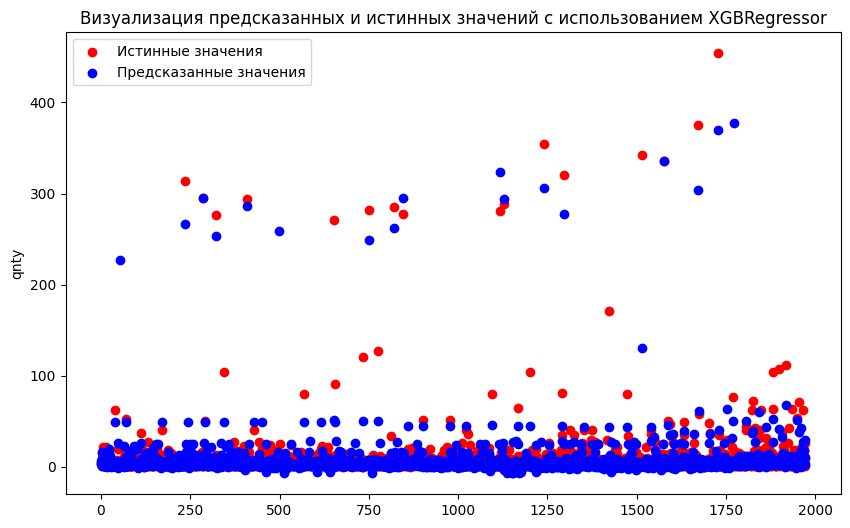

In [81]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(random_state=RANDOM_STATE)
xgb_reg.fit(X_train,
        y_train,
        verbose=False,
        )
# сначала я прогнал алгоритм  просто на данных sales, без информации о скидках, rmse была ~ 24
y_pred_xgb = evaluate(xgb_reg, X_test, y_test, 'XGBRegressor')

Видно, кстати, что продажи растут к Новому Году.

In [44]:
#y_test[20:40]

In [45]:
#y_pred_xgb[20:40]

## Простая линейная регрессия

RMSE на тестовых данных (декабрь 2023) c использованием LinearRegression: 17.30200593404954


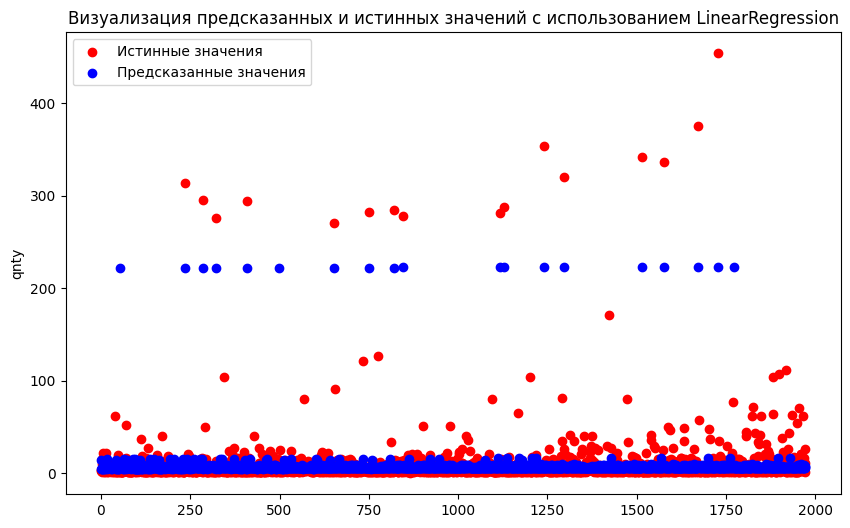

In [58]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin_reg = evaluate(lin_reg, X_test, y_test, 'LinearRegression')

## Support Vector Regression

In [49]:
'''
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X = sc_x.fit_transform(X_train)
y = sc_y.fit_transform(y_train.reshape(-1, 1))
'''

'\nfrom sklearn.preprocessing import StandardScaler\n\nsc_x = StandardScaler()\nsc_y = StandardScaler()\nX = sc_x.fit_transform(X_train)\ny = sc_y.fit_transform(y_train.reshape(-1, 1))\n'

In [50]:
# по непонятным мне причинам очень долго фитится и лагает
'''
from sklearn.svm import SVR

reg = SVR(kernel='rbf')
reg.fit(X_train, y_train)
X_grid = np.arange(min(X),max(X),step=0.1)
X_grid = X_grid.reshape((len(X_grid)),1)
plt.scatter(X, y,color='red')
'''

"\nfrom sklearn.svm import SVR\n\nreg = SVR(kernel='rbf')\nreg.fit(X_train, y_train)\nX_grid = np.arange(min(X),max(X),step=0.1)\nX_grid = X_grid.reshape((len(X_grid)),1)\nplt.scatter(X, y,color='red')\n"

## Decision Tree Regression

RMSE на тестовых данных (декабрь 2023) c использованием DecisionTreeRegressor: 20.48875676006816


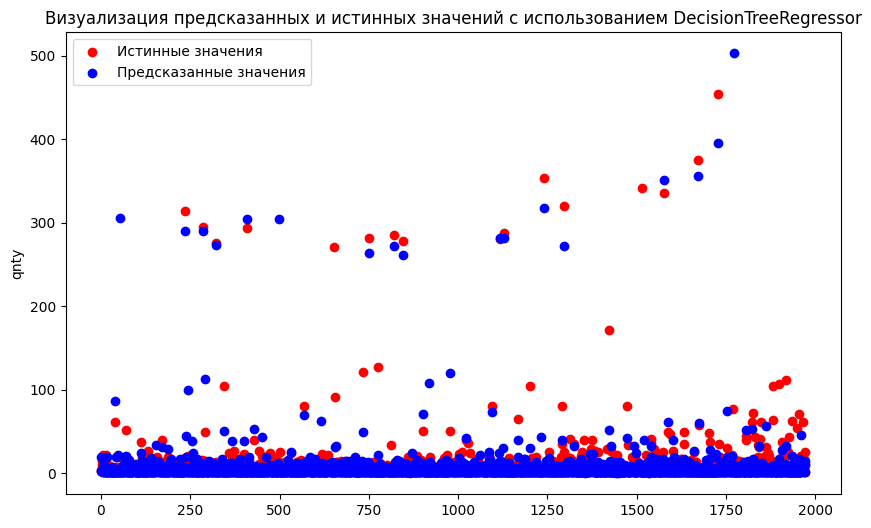

In [70]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_reg.fit(X_train, y_train)

y_pred_tree_reg = evaluate(tree_reg, X_test, y_test, 'DecisionTreeRegressor')

Визуально выглядит намного лучше! Однако метрика не так высока.

## Random Forest Regression


RMSE на тестовых данных (декабрь 2023) c использованием RandomForestRegressor: 18.147086015851155


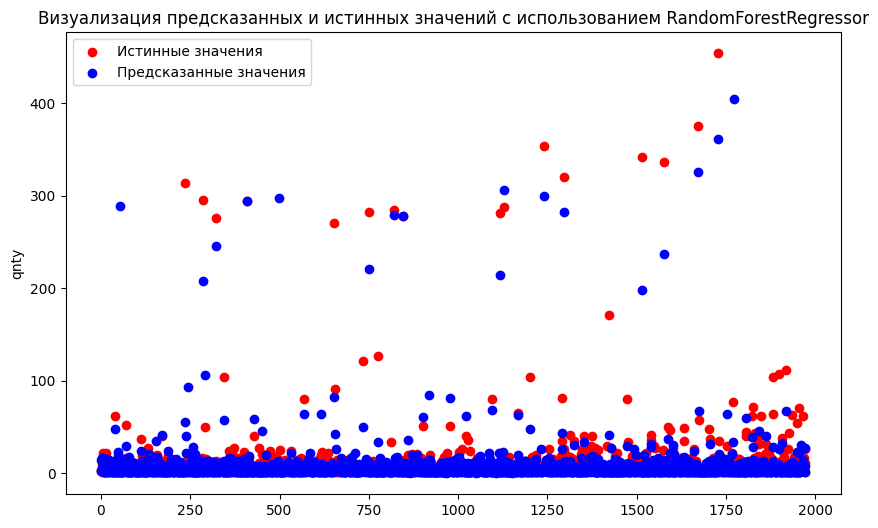

In [72]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE)
rf_reg.fit(X_train, y_train)

y_pred_rf_reg = evaluate(rf_reg, X_test, y_test, 'RandomForestRegressor')

Пока лучшая модель - XGB.

Подберем для нее лучшие параметры.

## Grid Search для XGB Regressor


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold # cross validation

param_grid = {
    #"objective": ["reg:squarederror"],
    "n_estimators":[5, 7, 10, 15, 20, 50, 100],
    'learning_rate': [.03, 0.05, .07],
    'max_depth': [4,5,6,7,8],
    "subsample": [0.8, 0.65, 0.5],
    "colsample_bytree": [0.7,0.9],
    "colsample_bylevel": [0.7,0.8],
    "random_state": [RANDOM_STATE],
}

kflod=KFold(n_splits=3,shuffle=True)

grid_search = GridSearchCV(xgb_reg, param_grid, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = kflod,  verbose=10) #scoring is the loss function type
grid_result = grid_search.fit(X_train, y_train)

print("Лучший результат по MSE: %f. Параметры: %s" % (grid_result.best_score_,grid_search.best_params_))

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits
Лучший результат по MSE: -237.955228. Параметры: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.5}


RMSE на тестовых данных (декабрь 2023) c использованием XGBRegressor (best): 14.448297041310719


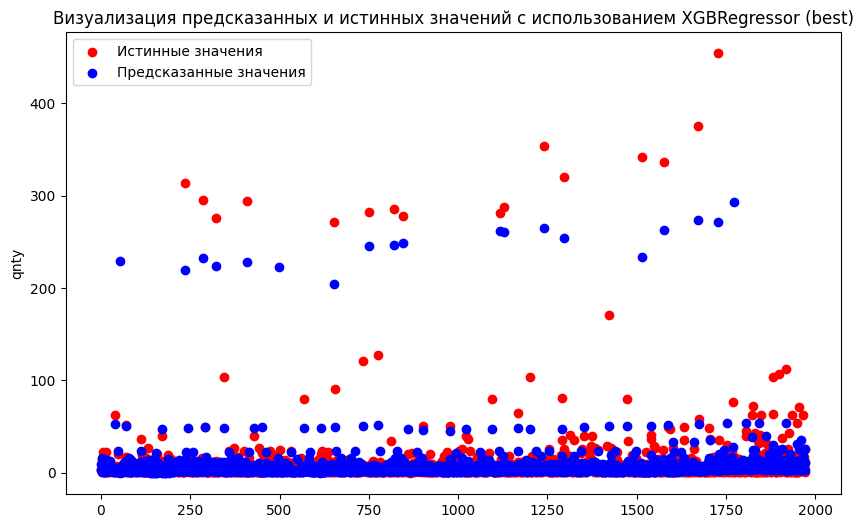

In [133]:
# Повторим эксперимент на декабре 2023 с лучшими параметрами

xgb_reg_best = xgb.XGBRegressor(**grid_search.best_params_)
xgb_reg_best.fit(X_train, y_train)
y_pred_xgb = evaluate(xgb_reg_best, X_test, y_test, 'XGBRegressor (best)')

# 6. Предсказания на январь 2024

## Есть ли у нас данные о скидках на 2024?

In [ ]:
discounts.date_starts=pd.to_datetime(discounts.date_start)
discounts.date_end=pd.to_datetime(discounts.date_end)

discounts['date_starts_day'] = discounts.date_starts.dt.day
discounts['date_starts_month'] = discounts.date_starts.dt.month
discounts['date_starts_year'] = discounts.date_starts.dt.year
discounts['date_end_day'] = discounts.date_end.dt.day
discounts['date_end_month'] = discounts.date_end.dt.month
discounts['date_end_year'] = discounts.date_end.dt.year
#discounts

In [112]:
discounts.date_starts_year.value_counts()

2023    523
2020    522
2021    509
2022    455
2024     72
Name: date_starts_year, dtype: int64

Отлично! Данные о скидках есть.

In [92]:
'''
ids_to_drop = set(ids_all).difference(set(ids_sales_in_dec_2023))
for id in ids_to_drop:
    ind = _sales[_sales.item_id == id].index
    _sales = _sales.drop(ind)
'''

In [113]:
_sales.head(1)

,date,item_id,qnty,day,month,year,is_discount,promo_typeCode,price_decrease
0,2017-01-01,100001,7.0,1,1,2017,0,0,0.0


## Создание датафрейма

Создадим датафрейм (как X_test по структуре), по которому модель будет строить предсказания

In [208]:
# да, коряво
days = []
item_ids = []
for id in ids_sales_in_dec_2023:
    for i in range(1, 32):
        days.append(i)
        item_ids.append(id)

In [105]:
days[25:33]

[26, 27, 28, 29, 30, 31, 1, 2]

In [102]:
len(days)

3007

In [209]:
X_jan_2024 = pd.DataFrame(data={'day': days})
X_jan_2024['month'] = 1
X_jan_2024['year'] = 2024
X_jan_2024['item_id'] = item_ids

X_jan_2024.head()

,day,month,year,item_id
0,1,1,2024,100545
1,2,1,2024,100545
2,3,1,2024,100545
3,4,1,2024,100545
4,5,1,2024,100545


Повторим процедуру добавления данных о скидках.

In [210]:
X_jan_2024['is_discount'] = 0
X_jan_2024[['promo_typeCode',	'price_decrease']] = 0
X_jan_2024.head(2)

,day,month,year,item_id,is_discount,promo_typeCode,price_decrease
0,1,1,2024,100545,0,0,0
1,2,1,2024,100545,0,0,0


In [211]:
#X_jan_2024.drop(['date'], axis=1, inplace=True)
dates = []
for _, row in X_jan_2024.iterrows():
    day = str(row.day)
    if row.day < 10:
        day = '0' + day

    month = str(row.month)
    if row.month < 10:
        month = '0' + month
    date = str(row.year) + '-' + month + '-' + day
    dates.append(date)

X_jan_2024['date'] = dates
X_jan_2024.date=pd.to_datetime(X_jan_2024.date)
X_jan_2024

,day,month,year,item_id,is_discount,promo_typeCode,price_decrease,date
0,1,1,2024,100545,0,0,0,2024-01-01
1,2,1,2024,100545,0,0,0,2024-01-02
2,3,1,2024,100545,0,0,0,2024-01-03
3,4,1,2024,100545,0,0,0,2024-01-04
4,5,1,2024,100545,0,0,0,2024-01-05
...,...,...,...,...,...,...,...,...
3002,27,1,2024,100662,0,0,0,2024-01-27
3003,28,1,2024,100662,0,0,0,2024-01-28
3004,29,1,2024,100662,0,0,0,2024-01-29
3005,30,1,2024,100662,0,0,0,2024-01-30


In [212]:
discounts_2024 = discounts[discounts.date_end_year == 2024]
len(discounts_2024), len(discounts)

(85, 2081)

In [213]:
for _, row in discounts_2024.iterrows(): # для каждой строки об акции
    subset_X_jan_2024 = X_jan_2024[X_jan_2024.item_id == row.item_id] # находим пул записей с item_id, которые затрагиваются данной акцией
    subset_X_jan_2024 = subset_X_jan_2024[(subset_X_jan_2024.date >= row.date_start) & (subset_X_jan_2024.date <= row.date_end)] # находим такие записи, которые затрагиваются данной акцией по сроку проведения
    ind = subset_X_jan_2024.index # берем индексы этих записей (индексы в исходном датасете)
    X_jan_2024.loc[ind,'is_discount'] = 1 # меняем поле "товар по скидке" на 1 (истинно)
    X_jan_2024.loc[ind,'promo_typeCode'] = row.promo_typeCode # добавляем информацию о скидке: тип акции и сумма скидки
    X_jan_2024.loc[ind,'price_decrease'] = row.price_decrease



In [155]:
#X_jan_2024.sort_values(by='item_id', ascending=True, inplace=True)
#X_jan_2024.year = 2024
X_jan_2024

,day,month,year,item_id,is_discount,promo_typeCode,price_decrease,date
1670,28,1,2024,11200,0,0,0.0,2024-01-28
1648,6,1,2024,11200,0,0,0.0,2024-01-06
1673,31,1,2024,11200,0,0,0.0,2024-01-31
1656,14,1,2024,11200,0,0,0.0,2024-01-14
1644,2,1,2024,11200,0,0,0.0,2024-01-02
...,...,...,...,...,...,...,...,...
1923,2,1,2024,100691,0,0,0.0,2024-01-02
1922,1,1,2024,100691,0,0,0.0,2024-01-01
1926,5,1,2024,100691,0,0,0.0,2024-01-05
1947,26,1,2024,100691,1,6,20.0,2024-01-26


In [156]:
######## ААА ПОРЯДОК ПЕРЕМЕННЫХ....ГОСПОДИ

_sales.drop(dec_2023.index).drop(['qnty', 'date'], axis=1).head(1)

,item_id,day,month,year,is_discount,promo_typeCode,price_decrease
0,100001,1,1,2017,0,0,0.0


In [216]:
X_jan_2024 = X_jan_2024[['item_id',	'day',	'month',	'year',	'is_discount',	'promo_typeCode',	'price_decrease']]
X_jan_2024

,item_id,day,month,year,is_discount,promo_typeCode,price_decrease
1670,11200,28,1,2024,0,0,0.0
1671,11200,29,1,2024,0,0,0.0
1672,11200,30,1,2024,0,0,0.0
1669,11200,27,1,2024,0,0,0.0
1668,11200,26,1,2024,0,0,0.0
...,...,...,...,...,...,...,...
1950,100691,29,1,2024,1,6,20.0
1951,100691,30,1,2024,1,6,20.0
1952,100691,31,1,2024,1,6,20.0
1936,100691,15,1,2024,0,0,0.0


In [217]:
# Готовим данные под формат для наших моделей
X_jan_2024_test = X_jan_2024.values

In [163]:
# для сравнения приведем на графике январь 2023
jan_2023 = _sales[(sales.date >= '2023-01-01') & (sales.date <= '2023-01-31')]
jan_2023.sort_values(by='item_id', ascending=True, inplace=True)

jan_2023

,date,item_id,qnty,day,month,year,is_discount,promo_typeCode,price_decrease
126544,2023-01-19,11200,332.0,19,1,2023,0,0,0.0
126379,2023-01-16,11200,274.0,16,1,2023,0,0,0.0
126079,2023-01-11,11200,291.0,11,1,2023,0,0,0.0
126788,2023-01-23,11200,274.0,23,1,2023,0,0,0.0
126074,2023-01-10,11200,219.0,10,1,2023,0,0,0.0
...,...,...,...,...,...,...,...,...,...
125866,2023-01-06,100686,4.0,6,1,2023,0,0,0.0
126898,2023-01-25,100686,2.0,25,1,2023,0,0,0.0
125707,2023-01-03,100686,2.0,3,1,2023,0,0,0.0
127084,2023-01-28,100686,2.0,28,1,2023,0,0,0.0


In [179]:
np.array(range(len(jan_2023.qnty)))*1.75

array([0.00000e+00, 1.75000e+00, 3.50000e+00, ..., 2.92250e+03,
       2.92425e+03, 2.92600e+03])

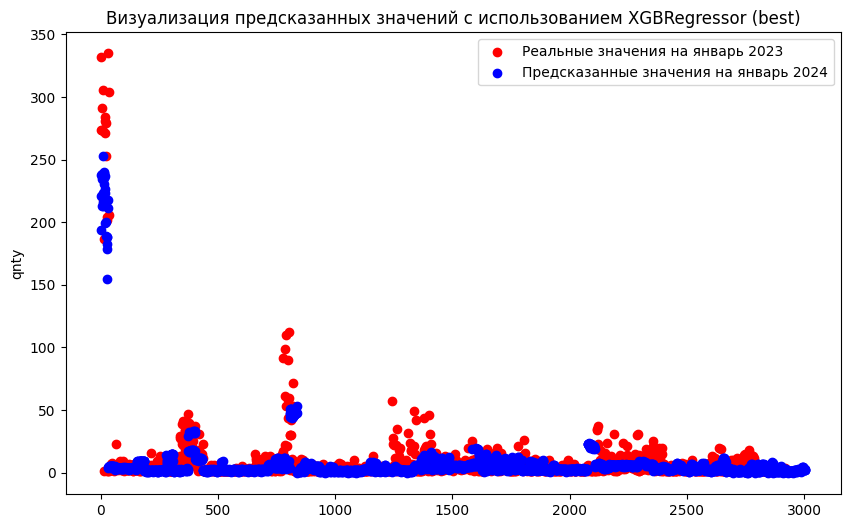

In [218]:
# может надо удалить из рассмотрения год?
y_pred_jan_2024 = xgb_reg_best.predict(X_jan_2024_test)

plt.scatter(np.array(range(len(jan_2023.qnty)))*1.75, jan_2023.qnty, color='red')
plt.scatter(range(len(y_pred_jan_2024)), y_pred_jan_2024, color='blue')
plt.title('Визуализация предсказанных значений c использованием XGBRegressor (best)')
plt.ylabel('qnty')
plt.legend(['Реальные значения на январь 2023', 'Предсказанные значения на январь 2024'])
plt.show()

Из-за того, что я предсказывал значения без пропусков дней, наблюдается небольшое смещение.

Эту проблему нужно решить, отшкалировав данные чтобы у них было одинаковое максимальное значение икса.

Я решил это "костылем" - умножил сетку иксов на 1.75 (не трогая сами предсказания) , чтобы выравнить данные на прямой.

Можно видеть, что данные очень неплохо подходят под прошлый январь.

Это я еще не удалял из января 2023 item_id, для которых не делались предсказания на 2024.

# 7. Выгрузка предсказаний

В тестовом указано, что разделитель в файле - точка с запятой (**;**)

Формат:

date - дата прогноза

item_id - Код товара

prediction - Количество товара (дробное число)

In [219]:
X_jan_2024['prediction'] = y_pred_jan_2024
X_jan_2024['date'] = dates
pred_jan_2024 = X_jan_2024[['date', 'item_id', 'prediction']]
pred_jan_2024.reset_index(drop=True, inplace=True)
pred_jan_2024

,date,item_id,prediction
0,2024-01-01,11200,221.003220
1,2024-01-02,11200,193.803604
2,2024-01-03,11200,238.014343
3,2024-01-04,11200,212.978210
4,2024-01-05,11200,234.392715
...,...,...,...
3002,2024-01-27,100691,2.368751
3003,2024-01-28,100691,2.410008
3004,2024-01-29,100691,2.196494
3005,2024-01-30,100691,1.860949


In [220]:
pred_jan_2024.to_csv('jan_2024_pred.csv', index=False, sep=';')
# несмотря на то что я указал index=False, данные выгружаются с индексом
# UPD - сработало, когда поменял местами index=False и sep=';' в аргументах функции. Очень странно.

In [222]:
# предсказания каждый раз чуть-чуть отличаются, так работает модель, что она может иногда выдать не строго один и тот же модель на одни и те входные данные
pred_jan_2024 = pd.read_csv('jan_2024_pred.csv', delimiter=';')
pred_jan_2024

,date,item_id,prediction
0,2024-01-01,11200,221.003220
1,2024-01-02,11200,193.803600
2,2024-01-03,11200,238.014340
3,2024-01-04,11200,212.978210
4,2024-01-05,11200,234.392720
...,...,...,...
3002,2024-01-27,100691,2.368751
3003,2024-01-28,100691,2.410008
3004,2024-01-29,100691,2.196494
3005,2024-01-30,100691,1.860949
